In [1]:
#basic package
import json
import tqdm
import os
import numpy as np
import glob
import pandas as pd
import sys
import time
import random
import datetime as dt
import math
from scipy.stats import pearsonr
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score
from scipy import stats
import collections
from collections import Counter
#plot
from matplotlib.colors import DivergingNorm
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
PACKAGE_PARENT = '../'
SCRIPT_DIR = os.path.dirname(os.path.realpath(os.path.join(os.getcwd(), os.path.expanduser('__file__'))))
sys.path.append(os.path.normpath(os.path.join(SCRIPT_DIR, PACKAGE_PARENT)))
import config_origins as config

In [3]:
#choose method to run the script on
name_method = 'ML-method'
#name_method = 'TD-method'

In [4]:
#initialise parameters
path_extracted_data = config.path_extracted_data
path_initial_data = config.path_initial_data
id_run = config.id_run
pal_ = config.pal_
pal_zone = config.pal_zone
pal_pens = config.pal_pens
dico_pen_ts = config.dico_pen_ts
pal_tracking_system = config.pal_tracking_system
path_extracted_data_cleaning = os.path.join(path_extracted_data,'Cleaning')
path_extracted_data_cleaning_model = os.path.join(path_extracted_data_cleaning,'model')  
path_extracted_data_cleaning_rawvscleaned = os.path.join(path_extracted_data_cleaning,'Raw&Cleaned')  
path_extracted_data_cleaning_rawvscleaned_MLP = os.path.join(path_extracted_data_cleaning_rawvscleaned, 'MLP')
if not os.path.exists(path_extracted_data_cleaning_rawvscleaned_MLP):
    os.makedirs(path_extracted_data_cleaning_rawvscleaned_MLP)

# Download data

In [5]:
df_var = pd.read_csv(os.path.join(path_extracted_data_cleaning_rawvscleaned, name_method+'_daily_ALL_variables.csv'), sep=';', 
                 parse_dates=['level'], dayfirst=True) 
print(df_var.shape)
df_var['tracking_system'] = df_var['PenID'].map(lambda x: dico_pen_ts[x])
df_var['PenID'] = df_var['PenID'].map(lambda x: 'Pen '+str(int(x)))
#keep days with same artificial light (not that due to technical issue, sometimes we loose few hours on specific days for 
#some animals, thus we will remove these)
df_var = df_var[df_var['verification_daily_total_duration']==54000]
print(df_var.shape)
print('You are analysing %d days'%len(df_var['level'].unique()))
df_var.head(3)

(19992, 126)
(17460, 127)
You are analysing 57 days


HenID      level  duration_1_Zone  duration_2_Zone  duration_3_Zone  \
1  hen_131 2020-11-14            405.0          17084.0          23716.0   
2  hen_131 2020-11-15              0.0          16576.0          28684.0   
3  hen_131 2020-11-16              0.0          14508.0          29621.0   

   duration_4_Zone  duration_5_Zone  verification_daily_total_duration  \
1           2512.0          10283.0                            54000.0   
2           2187.0           6553.0                            54000.0   
3           3091.0           6780.0                            54000.0   

                                   dur_values  \
1  [405.0, 17084.0, 23716.0, 2512.0, 10283.0]   
2     [0.0, 16576.0, 28684.0, 2187.0, 6553.0]   
3     [0.0, 14508.0, 29621.0, 3091.0, 6780.0]   

                               dur_values_normalized  ...  \
1  [0.0075, 0.31637037037037036, 0.43918518518518...  ...   
2  [0.0, 0.30696296296296294, 0.5311851851851852,...  ...   
3  [0.0, 0.26866666666666666, 0.548537037037037, ...  ...   

  temperature_night20_2_median temperature_night20_2_max  \
1                         26.0                      28.0   
2                         28.0                      29.0   
3                         27.0                      28.0   

  temperature_night20_2_var  \
1                  0.750000   
2                  0.098765   
3                  0.693673   

                         list_of_MovementCounter_day len_MovementCounter_day  \
1  [14.0, 69.0, 47.0, 79.0, 50.0, 46.0, 64.0, 75....                    90.0   
2  [16.0, 70.0, 57.0, 55.0, 60.0, 65.0, 73.0, 73....                    90.0   
3  [64.0, 23.0, 75.0, 52.0, 75.0, 48.0, 52.0, 58....                    90.0   

   MovementCounter_day_amount_nnactivity MovementCounter_day_max  \
1                               0.011111                    95.0   
2                               0.033333                    91.0   
3                               0.022222                    94.0   

  MovementCounter_day_mean      type       tracking_system  
1                59.077778  cleaning  TrackingSystem 10-12  
2                57.922222  cleaning  TrackingSystem 10-12  
3                54.944444  cleaning  TrackingSystem 10-12  

[3 rows x 127 columns]

In [6]:
np.nanmean(df_var['Total_number_transition'].tolist()), np.nanmedian(df_var['Total_number_transition'].tolist())

(66.06884306987399, 64.0)

# Generate dataframe for modelling in R

HenID   PenID      level      type  nbr_stays_1_Zone  nbr_stays_2_Zone  \
1  hen_131  Pen 10 2020-11-14  cleaning               2.0              18.0   
2  hen_131  Pen 10 2020-11-15  cleaning               0.0              12.0   
3  hen_131  Pen 10 2020-11-16  cleaning               0.0              10.0   

   nbr_stays_3_Zone  nbr_stays_4_Zone  nbr_stays_5_Zone  
1              20.0               7.0               4.0  
2              16.0               7.0               4.0  
3              12.0               2.0               2.0

level    HenID   PenID      type Trackingsystem_Zone  nbr_of_stay
0 2020-11-14  hen_131  Pen 10  cleaning    nbr_stays_1_Zone          2.0
1 2020-11-15  hen_131  Pen 10  cleaning    nbr_stays_1_Zone          0.0
2 2020-11-16  hen_131  Pen 10  cleaning    nbr_stays_1_Zone          0.0

(3189, 9) (40461, 9)
(43650, 9)
(40461, 9)


type      level    HenID  PenID Trackingsystem_Zone  cleaning   raw  \
1    2020-11-13  hen_147  Pen 8    nbr_stays_2_Zone      24.0  25.0   
2    2020-11-13  hen_147  Pen 8    nbr_stays_3_Zone      27.0  36.0   
3    2020-11-13  hen_147  Pen 8    nbr_stays_4_Zone       4.0  12.0   

type  Difference_r-cl  absolute_difference  diff_rate  
1                 1.0                  1.0   0.960000  
2                 9.0                  9.0   0.750000  
3                 8.0                  8.0   0.333333

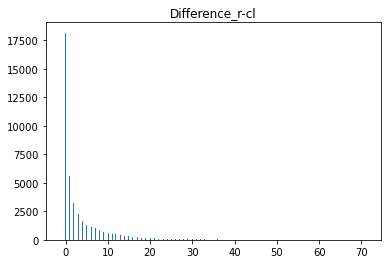

------------------------keep hens that have more than 54 days...
(40461, 9) (35792, 9)


HenID  level  has_more_xdays
0    hen_1     56            True
1   hen_10     56            True
2  hen_100      9           False

57
number of hens involved: 140
------------------------Add the weather...
(201, 6)


date  temperature_C  humidity_avgpercent  had_rainorsnow  \
0 2020-09-29         12.000               92.125               0   
1 2020-09-30         12.250               80.125               1   
2 2020-10-01         14.125               74.875               0   

             moon_name  Illumination_percentage  
0  waxing gibbous moon                 94.56625  
1  waxing gibbous moon                 98.01625  
2  waxing gibbous moon                 99.66250

(35792, 9)
(35792, 15)


level    HenID  PenID Trackingsystem_Zone  cleaning   raw  \
0 2020-11-13  hen_147  Pen 8    nbr_stays_2_Zone      24.0  25.0   
1 2020-11-13  hen_147  Pen 8    nbr_stays_3_Zone      27.0  36.0   
2 2020-11-13  hen_147  Pen 8    nbr_stays_4_Zone       4.0  12.0   

   Difference_r-cl  absolute_difference  diff_rate       date  temperature_C  \
0              1.0                  1.0   0.960000 2020-11-13         10.875   
1              9.0                  9.0   0.750000 2020-11-13         10.875   
2              8.0                  8.0   0.333333 2020-11-13         10.875   

   humidity_avgpercent  had_rainorsnow             moon_name  \
0                73.75               1  waning crescent moon   
1                73.75               1  waning crescent moon   
2                73.75               1  waning crescent moon   

   Illumination_percentage  
0                  4.47375  
1                  4.47375  
2                  4.47375

In [7]:
li_var = ['nbr_stays_1_Zone','nbr_stays_2_Zone','nbr_stays_3_Zone','nbr_stays_4_Zone','nbr_stays_5_Zone']
display(df_var[['HenID','PenID','level', 'type']+li_var].head(3))
#put all bouts into a columns
df_modelling = pd.melt(df_var, id_vars=['level', 'HenID', 'PenID', 'type'], value_vars=li_var)
df_modelling.rename(columns={'variable':'Trackingsystem_Zone', 'value':'nbr_of_stay'}, inplace=True)
display(df_modelling.head(3))
df_modelling = df_modelling.pivot(index=['level','HenID','PenID','Trackingsystem_Zone'], 
                      columns='type',values='nbr_of_stay').reset_index()
df_modelling['Difference_r-cl'] = df_modelling.apply(lambda x: x['raw']-x['cleaning'], axis=1)
df_modelling['absolute_difference'] = df_modelling['Difference_r-cl'].map(lambda x: abs(x))
#if the tracking system do not record any trnasitions in a zone over a day for a particular animal, then there is nothing to be
#compared, we will remove it simply
df_modelling['diff_rate'] = df_modelling.apply(lambda x: min(x['cleaning'],x['raw'])/max(x['cleaning'],x['raw']) if x['raw']!=0 else np.nan, axis=1)
print(df_modelling[df_modelling['diff_rate'].isnull()].shape, df_modelling[~df_modelling['diff_rate'].isnull()].shape)
#df_modelling['level_continuous'] = df_modelling['level'].map(lambda x: (x-df_modelling['level'].min()).days)
#display(df_modelling[df_modelling['Difference_r-cl']<0]) #checked manually: was correct: when the model remove the last transtion of the 
#night, then the bird will start his day / first stay in a different zone, which at the end can be adding a stay in this zone.
print(df_modelling.shape)
df_modelling = df_modelling[~df_modelling.isnull().any(axis=1)]
print(df_modelling.shape)
display(df_modelling.head(3))
#plot
plt.hist(df_modelling['Difference_r-cl'].dropna(),bins='auto');
plt.title('Difference_r-cl')
plt.show()

print('------------------------keep hens that have more than 54 days...')
df_ = df_modelling.groupby(['HenID'])['level'].agg(lambda x: len(set(x))).reset_index()
#display(df_['level'].value_counts())
df_['has_more_xdays'] = df_['level'].map(lambda x: x>=54)
li_hen2keep = df_[df_['has_more_xdays']]['HenID'].unique()
print(df_modelling.shape, df_modelling[df_modelling['HenID'].isin(li_hen2keep)].shape)
df_modelling = df_modelling[df_modelling['HenID'].isin(li_hen2keep)]
display(df_.head(3))
print(len(df_modelling['level'].unique()))
print('number of hens involved: %d'%len(df_modelling['HenID'].unique()))
      
print('------------------------Add the weather...')
path_weather = os.path.join(r'C:\Users\camil\Desktop\vm_exchange\PhD_Data\Weather','df_daily_weather.csv')
df_weather = pd.read_csv(path_weather, sep=';', parse_dates=['date'])
print(df_weather.shape)
display(df_weather.head(3))
print(df_modelling.shape)
df_modelling = pd.merge(df_modelling, df_weather, right_on='date', left_on='level', how='left')
print(df_modelling.shape)
display(df_modelling.head(3))

#save
li_modelVAR =  ['absolute_difference', 'diff_rate', 'PenID','Trackingsystem_Zone','HenID','level','humidity_avgpercent']
df_modelling.filter(li_modelVAR).to_csv(os.path.join(path_extracted_data_cleaning_rawvscleaned,
                                               name_method+'_df4DifferenceModelling.csv'), index=False, sep=';')

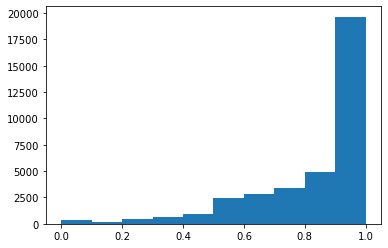

In [16]:
plt.hist(df_modelling['diff_rate'])
plt.show();

### Scatter plot: per zone, per pens OVER ENTIRE PERIOD

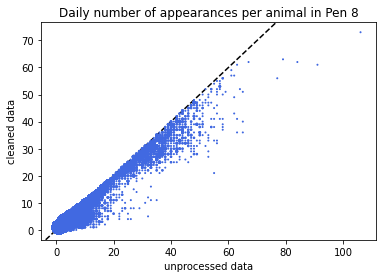

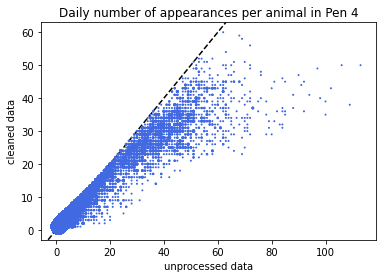

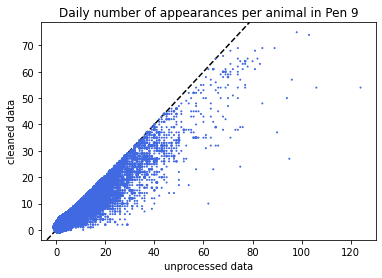

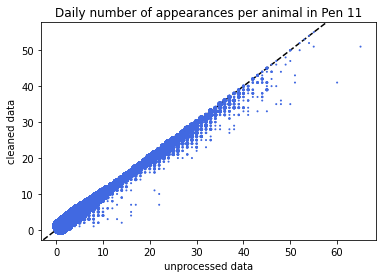

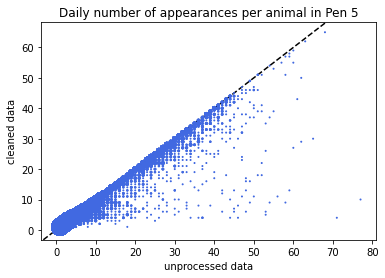

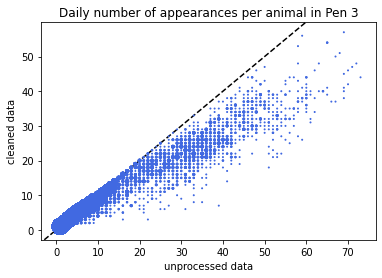

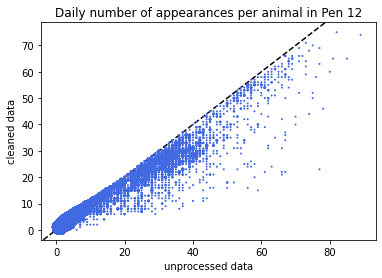

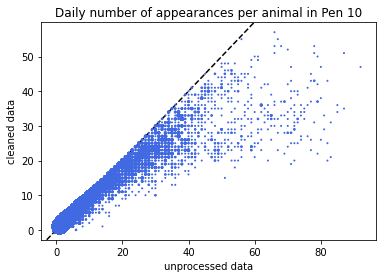

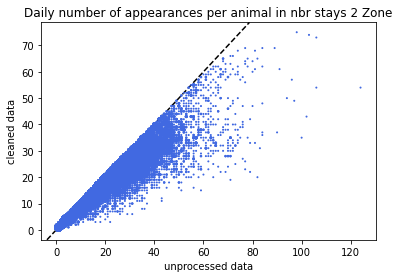

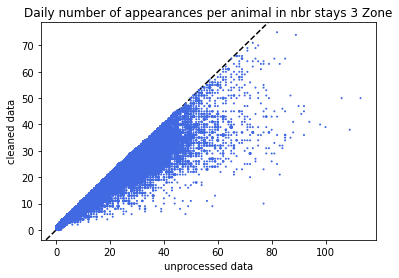

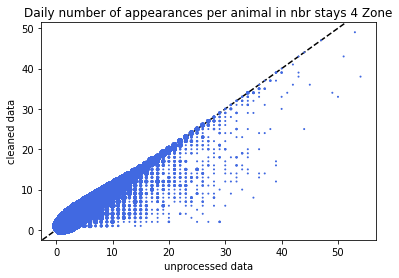

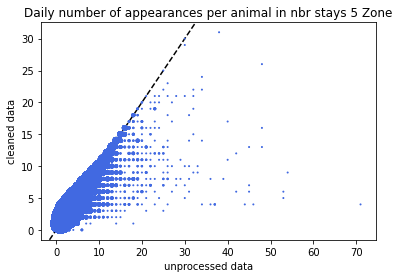

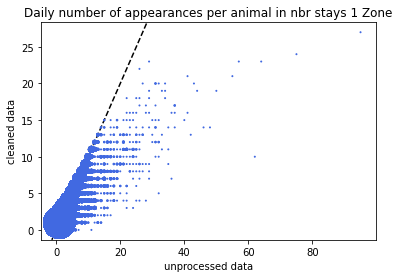

In [9]:
#visuals of the actual number of appearances per methods for curiosity/better understanding
for type_ in ['PenID','Trackingsystem_Zone']:
    for y_ in df_modelling[type_].unique():
        x = np.array(df_modelling[df_modelling[type_]==y_]['raw'].tolist())
        y = np.array(df_modelling[df_modelling[type_]==y_]['cleaning'].tolist())
        c = Counter(zip(x,y))
        # create a list of the sizes, here multiplied by 10 for scale
        s = [1*c[(xx,yy)] for xx,yy in zip(x,y)]
        plt.scatter(x, y, s=s, color = 'royalblue')
        plt.xlabel('unprocessed data')
        plt.ylabel('cleaned data')
        plt.title('Daily number of appearances per animal in '+y_.replace('_',' '))
        #add diagonal line
        plt.axline((0, 0), slope=1, c="black", ls="--", zorder=0)
        #save and show
        plt.savefig(os.path.join(path_extracted_data_cleaning_rawvscleaned, name_method+"_NbrStay_"+y_+".png"),
                    dpi=300,format='png',bbox_inches='tight')
        plt.show();

# EV per zones, per pens

In [10]:
#to avoid impact of time on the mvt of the chicken, we will selected the days randomly across all possible days, and do several
#such plot to see if the patterns is still the same, but we dont aggregate all as the more the nbr of days increase, the least
#possibilities exists, and hence less variation by definition
random.seed(0)
li_df = []
for nbr_days in tqdm.tqdm(range(2,30)):
    for henid,df_h in df_modelling.groupby(['HenID']): 
        #select random days without repeating elements
        #with sets as several row per date,henid (one per variable)
        li_date = random.sample(list(set(df_h['level'].tolist())), nbr_days)
        df_h_ = df_h[df_h['level'].isin(li_date)]
        #compute differences between unprocessed and cleaned dataset
        li1 = df_h_['raw'].tolist()
        li2 = df_h_['cleaning'].tolist()
        explained_variance = explained_variance_score(li1, li2) #not symmetrics
        li_df.append({'HenID':henid, 'explained_variance':explained_variance,
                      'number of days':nbr_days, 'li_date':li_date, 'nbrObservations':len(li1), 'PenID':df_h['PenID'].iloc[0]})
df_impact = pd.DataFrame(li_df)
print(df_impact.shape)
df_impact.head(3)

100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:04<00:00,  6.08it/s]

(3920, 6)


HenID  explained_variance  number of days  \
0    hen_1            0.690744               2   
1   hen_10            0.977995               2   
2  hen_101            0.998606               2   

                                      li_date  nbrObservations   PenID  
0  [2020-12-29 00:00:00, 2020-12-08 00:00:00]               10   Pen 9  
1  [2020-12-19 00:00:00, 2021-01-02 00:00:00]                9  Pen 11  
2  [2020-12-20 00:00:00, 2020-11-26 00:00:00]                9   Pen 5

In [11]:
#as the pen*zone is significant, but the main effect too, as quantitatif value we will generate a table of EV per zone per pen
#with one observation per chicken
df_modelling.head(3)

level    HenID  PenID Trackingsystem_Zone  cleaning   raw  \
0 2020-11-13  hen_147  Pen 8    nbr_stays_2_Zone      24.0  25.0   
1 2020-11-13  hen_147  Pen 8    nbr_stays_3_Zone      27.0  36.0   
2 2020-11-13  hen_147  Pen 8    nbr_stays_4_Zone       4.0  12.0   

   Difference_r-cl  absolute_difference  diff_rate       date  temperature_C  \
0              1.0                  1.0   0.960000 2020-11-13         10.875   
1              9.0                  9.0   0.750000 2020-11-13         10.875   
2              8.0                  8.0   0.333333 2020-11-13         10.875   

   humidity_avgpercent  had_rainorsnow             moon_name  \
0                73.75               1  waning crescent moon   
1                73.75               1  waning crescent moon   
2                73.75               1  waning crescent moon   

   Illumination_percentage  
0                  4.47375  
1                  4.47375  
2                  4.47375

PenID Trackingsystem_Zone  \
0  Pen 10    nbr_stays_1_Zone   
1  Pen 10    nbr_stays_2_Zone   
2  Pen 10    nbr_stays_3_Zone   

                                            cleaning  \
0  [2.0, 9.0, 7.0, 1.0, 4.0, 1.0, 6.0, 3.0, 3.0, ...   
1  [18.0, 23.0, 25.0, 9.0, 28.0, 19.0, 19.0, 3.0,...   
2  [20.0, 22.0, 27.0, 11.0, 30.0, 17.0, 22.0, 4.0...   

                                                 raw        EV  
0  [3.0, 10.0, 8.0, 1.0, 4.0, 1.0, 6.0, 5.0, 3.0,...  0.948616  
1  [21.0, 30.0, 28.0, 12.0, 31.0, 19.0, 22.0, 4.0...  0.617873  
2  [23.0, 27.0, 31.0, 12.0, 32.0, 18.0, 25.0, 6.0...  0.634785

Trackingsystem_Zone  nbr_stays_1_Zone  nbr_stays_2_Zone  nbr_stays_3_Zone  \
PenID                                                                       
Pen 10                       0.948616          0.617873          0.634785   
Pen 11                       0.917807          0.954477          0.965586   
Pen 12                       0.964528          0.768390          0.803075   
Pen 3                        0.943337          0.818532          0.796720   
Pen 4                        0.966906          0.684115          0.610798   
Pen 5                        0.910346          0.980649          0.710244   
Pen 8                        0.470719          0.901677          0.926879   
Pen 9                        0.607200          0.840418          0.854320   

Trackingsystem_Zone  nbr_stays_4_Zone  nbr_stays_5_Zone  
PenID                                                    
Pen 10                       0.973902          0.878513  
Pen 11                       0.996506          0.738676  
Pen 12                       0.987113          0.617752  
Pen 3                        0.970455          0.862372  
Pen 4                        0.736245          0.922506  
Pen 5                        0.987951          0.322370  
Pen 8                        0.742763          0.813360  
Pen 9                        0.732502          0.765295

[[0.94861588 0.61787294 0.63478471 0.9739016  0.87851267]
 [0.91780689 0.9544765  0.96558562 0.99650579 0.73867585]
 [0.96452754 0.76838953 0.80307459 0.98711334 0.61775207]
 [0.94333693 0.81853246 0.79672046 0.97045515 0.8623724 ]
 [0.96690585 0.68411484 0.6107983  0.7362449  0.92250616]
 [0.91034591 0.98064904 0.71024432 0.9879506  0.32237027]
 [0.47071866 0.90167734 0.92687877 0.74276308 0.81336003]
 [0.60719981 0.84041801 0.85432009 0.73250171 0.76529512]]


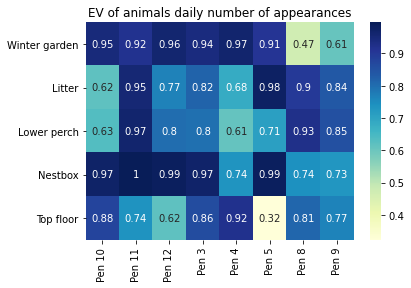

In [12]:
df_quantitatif = df_modelling.groupby(['PenID','Trackingsystem_Zone'])[['cleaning','raw']].agg(lambda x: list(x)).reset_index()
df_quantitatif['EV'] = df_quantitatif.apply(lambda x: explained_variance_score(x['raw'], x['cleaning']), axis=1)
display(df_quantitatif.head(3))
df_quantitatif = df_quantitatif.pivot(values='EV',index='PenID',columns='Trackingsystem_Zone')
display(df_quantitatif)
M = df_quantitatif.to_numpy()
dico_x_name = {'nbr_stays_1_Zone':'Winter garden',
                 'nbr_stays_2_Zone':'Litter',
                 'nbr_stays_3_Zone':'Lower perch',
                 'nbr_stays_4_Zone':'Nestbox',
                 'nbr_stays_5_Zone':'Top floor'}
print(M)
sns.heatmap(M.transpose(), xticklabels=df_quantitatif.index.tolist(), 
            yticklabels=[dico_x_name[x] for x in df_quantitatif.columns.tolist()], cmap="YlGnBu",
           annot=True)
plt.title('EV of animals daily number of appearances')
plt.savefig(os.path.join(path_extracted_data_cleaning_rawvscleaned, name_method+'_EV_ZonePerPen.png'),format='png',dpi=300)
plt.show()

# Difference of behavioural variables

In [13]:
#display(list((df_var.columns)))

In [14]:
df_var[['night_Total_number_transition', 'Total_number_transition', 'is_mvt_night', 'skew_duration']]

night_Total_number_transition  Total_number_transition  is_mvt_night  \
1                                0.0                     50.0           0.0   
2                                0.0                     38.0           0.0   
3                                0.0                     25.0           0.0   
4                                0.0                     44.0           0.0   
5                                0.0                     65.0           0.0   
...                              ...                      ...           ...   
19870                            0.0                     50.0           0.0   
19871                            0.0                     68.0           0.0   
19872                            0.0                     49.0           0.0   
19873                            0.0                     31.0           0.0   
19874                            0.0                     85.0           0.0   

       skew_duration  
1           1.327357  
2           1.425021  
3           0.945491  
4           1.468806  
5           1.198634  
...              ...  
19870       4.198257  
19871       4.343748  
19872       4.446708  
19873       2.784019  
19874       5.553965  

[17460 rows x 4 columns]

In [15]:
#define color of the hen depending on the median of it total nbr of transition over the overall period
#a variables that cant be controlled thorugh video bservation (night)
#an important variables: vertical_travel_distance
#a more complex variables: kurtosis_duration, skew_duration, 
#other incase: in_WG_15mnAfterOpening, vertical_travel_distance, activity_95percentile_sec
li_v = ['night_Total_number_transition', 'Total_number_transition', 'is_mvt_night', 'skew_duration']
li_df = []
for y_ in li_v:  
    #data: one colomn for the raw and one for the cleaned
    df_plt = df_var[['HenID','level', 'type', y_]].copy()
    df_plt = df_plt.pivot(index=['HenID','level'], columns='type',values=y_).reset_index()
    #print(df_plt.shape)
    df_plt = df_plt[~df_plt.isnull().any(axis=1)]
    #print(df_plt.shape)
    #display(df_plt.head(3))        
    x = np.array(df_plt['raw'].tolist())
    y = np.array(df_plt['cleaning'].tolist())

    #measures
    Explvarscore = explained_variance_score(x, y)
    RMSE = math.sqrt(mean_squared_error(x, y))
    MADIF = mean_absolute_error(x, y)
    rcoeff2, p_value2 = pearsonr(x, y)
    li_df.append({'variable':y_, 'Explvarscore':Explvarscore, 'RMSE':RMSE, 'MADIF':MADIF, 'rcoeff2':rcoeff2, 'p_value2':p_value2})
df_res = pd.DataFrame(li_df)
df_res.to_csv(os.path.join(path_extracted_data_cleaning_rawvscleaned,name_method+'_BehaviouralVariablesDifferences.csv'), sep=';', 
              index=False)
df_res

variable  Explvarscore       RMSE      MADIF  \
0  night_Total_number_transition      0.247011  12.821667   1.439908   
1        Total_number_transition      0.762084  23.233577  15.571821   
2                   is_mvt_night      0.910862   0.144886   0.020992   
3                  skew_duration      0.860663   0.588849   0.388923   

    rcoeff2  p_value2  
0  0.512241       0.0  
1  0.883889       0.0  
2  0.954905       0.0  
3  0.928176       0.0

# Visualise the MLP's differences

#for being more reproductible, we open the file that was saved from cleaning
df = pd.read_csv(os.path.join(path_extracted_data_cleaning_rawvscleaned, id_run+name_method+'_Rawdata&Model.csv'), sep=';', 
                 parse_dates=['Timestamp','date'], dayfirst=True) 
print(df.shape)
df.head(3)

START_TIME = time.perf_counter()
#choose specific dates to plot, November is better as hens starts to move more and the algo have never seen it
dmin = dt.datetime(2020,11,13)
dmax = dt.datetime(2020,11,22)
#df_ = df[(df['date']<dt.datetime(2020,11,16))&(df['date']>dt.datetime(2020,11,10))]
df_ = df[(df['date']<=dmax)&(df['date']>=dmin)].copy()
#only print the hens with at least one transition per day (simplicity and interestignly)
#to sort the yaxis
dico_zone_order = {'1_Zone':0, '2_Zone':1, '3_Zone':2, '4_Zone':3, '5_Zone':4}
li_ts = ['Trackingsystem_Zone','Model_Zone']
li_date = df_['date'].unique()
#for each batch draw 2 timeseries, the raw one and the model one
for henID, df_plt in tqdm.tqdm(df_.groupby(['HenID'])):
    df_plt = df_plt.sort_values(['Timestamp']).copy()
    c = len(li_ts) ; l = len(li_date)
    fig, ax = plt.subplots(figsize=(c*5, l*1))
    i = 1
    if len(df_plt['date'].unique())==len(li_date):
        mi = min(df_plt['Timestamp'].tolist()) ; ma = max(df_plt['Timestamp'].tolist())
        Daterange = pd.date_range(start = mi+dt.timedelta(seconds=(60-mi.second)), 
                                  end = ma-dt.timedelta(seconds=(ma.second+1)), 
                                  freq = 'S') 
        df_plt_ = df_plt.copy()
        df_plt_.set_index('Timestamp', inplace=True)
        df_plt_ = df_plt_.reindex(Daterange, method='ffill').reset_index()
        df_plt_.rename(columns={'index':'Timestamp'}, inplace=True)
        #add date again, as the reindexing also extended the date
        df_plt_['date'] = df_plt_['Timestamp'].map(lambda x: dt.datetime.date(x))
        #remove first & last date
        df_plt_ = df_plt_[~df_plt_['date'].isin([max(df_plt_['date'].tolist()),min(df_plt_['date'].tolist())])]
        #put xlabel into numbers for the ploting
        df_plt_['Trackingsystem_Zone'] = df_plt_['Trackingsystem_Zone'].map(lambda x: int(dico_zone_order[x]))       
        for d, df_plt__ in df_plt_.groupby(['date']):
            for v in li_ts:
                df_plt___ = df_plt__.copy()
                if v=='Model_Zone':
                    df_plt___ = df_plt___[df_plt___['prediction']==1]
                plt.subplot(l,c,i)
                plt.tight_layout(pad=0.3) #add spacing between each plot
                if i%2==1:
                    plt.yticks([0,1,2,3,4], ['Winter garden', 'Litter', 'Lower perch','Nestbox','Top floor'])#, rotation='vertical')
                else:
                    plt.yticks([0,1,2,3,4], ['','','','',''])
                if i in [1,2]:
                    plt.title(v.replace('_',' '), size=13)
                i = i+1
                plt.plot(df_plt___['Timestamp'].tolist(), df_plt___['Trackingsystem_Zone'].tolist(), 
                         color=pal_[v], linewidth=1)
                li_hour = pd.date_range(start = d,  end = d+dt.timedelta(days=1), freq = 'H')
                plt.xticks(li_hour , [str(i.hour)+'h' for i in li_hour], fontsize=5)                
                plt.yticks(fontsize=8)
                plt.xlabel(str(d).split('T')[0], size=7)
                plt.ylim(0, 4.2)  
        plt.savefig(os.path.join(path_extracted_data_cleaning_rawvscleaned_MLP,
                                 name_method+'_'+henID+'_'+str(dmin).split(' ')[0]+'_'+str(dmax).split(' ')[0]+'.png'), 
                    format='png', bbox_inches='tight', dpi=300)
    plt.clf()
    plt.close("all")    
END_TIME = time.perf_counter()
print ("Total running time: %.2f mn" %((END_TIME-START_TIME)/60))
#hen4, 22.10.2020: flickering. solved?